In [21]:
%pip install qiskit -U
%pip install qiskit-ibm-runtime -U

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [49]:
import qiskit_ibm_runtime
print(qiskit_ibm_runtime.version.get_version_info())

0.9.4


# Real quantum computer

## [Background on the various packages](https://github.com/Qiskit/qiskit-ibm-provider/blob/main/docs/tutorials/Migration_Guide_from_qiskit-ibmq-provider.ipynb)
- [Qiskit IBM Runtime](https://github.com/Qiskit/qiskit-ibm-runtime) - [pypi](https://pypi.org/project/qiskit-ibm-runtime) - Qiskit Runtime is a new architecture offered by IBM Quantum that streamlines quantum computations. It is designed to use classical compute resources to execute quantum circuits with more efficiency on quantum processors.
- [Qiskit IBM Provider](https://github.com/Qiskit/qiskit-ibm-provider) - [pypi](https://pypi.org/project/qiskit-ibm-provider) - This project contains a provider that allows accessing the IBM Quantum systems and simulators.
- [Qiskit IBM Experiment](https://github.com/Qiskit/qiskit-ibm-experiment) - [pypi](https://pypi.org/project/qiskit-ibm-experiment) - This project contains a service that allows accessing the IBM Quantum experiment database.


## Setup

Overview:
- [Account Setup steps](https://github.com/Qiskit/qiskit-ibm-runtime#account-setup) (IBM Cloud or IBM Quantum)
- [IBM Cloud - Getting started instructions](https://cloud.ibm.com/docs/quantum-computing?topic=quantum-computing-get-started)

Steps to access __IBM Quantum__ instance:
- [Get your API key](https://quantum-computing.ibm.com/account) and save it in .env as QISKIT_IBM_TOKEN
- use channel="ibm_quantum" when creating the service

OR - Steps to access __IBM Cloud__ instance:

- [Create a quantum Instance on IBM Cloud](https://cloud.ibm.com/quantum/instances)
- [Create an IBM Cloud API Key](https://cloud.ibm.com/iam/apikeys)
- use channel="ibm_cloud" when creating the service

In [22]:
ibmcloudinstance="crn:v1:bluemix:public:quantum-computing:us-east:a/0d6f8e0db0a1523f2ca61c2cb55c893b:150e4c08-58e0-43f3-9484-203044277dbf::"

In [23]:
# Load API Key
import os
from dotenv import load_dotenv
load_dotenv() # take environment variables from .env.
quiskit_api_key = os.environ.get("QISKIT_IBM_TOKEN")
assert quiskit_api_key is not None

In [24]:
# Connect to ibm quantum service
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum", token=quiskit_api_key)

if False:
    # Optional - save credentials to disk
    try:
        QiskitRuntimeService.save_account(channel="ibm_quantum", token=quiskit_api_key)
    except:
        print("Account info already saved")
    # Then you can login without args
    service = QiskitRuntimeService()

In [25]:
# display current supported backends
for backend in service.backends():
    print(f"{backend.name},    qubits:{backend.num_qubits},    status:{backend.status().status_msg},   pending_jobs:{backend.status().pending_jobs}")

TranspilerError: "The number of qubits for Instruction(name='cx', num_qubits=2, num_clbits=0, params=[]) does not match the number of qubits in the properties dictionary: (0,)"

## Test backend on simulator

In [ ]:
program_inputs = {'iterations': 1}
backend = service.least_busy(simulator=True, operational=True)
print(f"least_busy simulator backend: {backend.name}")
options = {"backend": backend.name}
job = service.run(program_id="hello-world",
                  options=options,
                  inputs=program_inputs
                 )
print(f"job id: {job.job_id()}")
result = job.result()
print(result)

least_busy simulator backend: simulator_mps
job id: chf46vfppn69h5pvhvig
Hello, World!


[Check jobs on web console](https://quantum-computing.ibm.com/jobs)

## Run on a real quantum device

In [28]:
# 2. Ask IBM Quantum for its least busy device that isn't a simulator.
backend = service.least_busy(simulator=False, operational=True)
print(f'least_busy real backend: {backend.name}')
print(f"backend info: {backend.name},    qubits:{backend.num_qubits},    status:{backend.status().status_msg},   pending_jobs:{backend.status().pending_jobs}")
print(f"backend coupling_map:{backend.coupling_map}")

least_busy real backend: ibmq_manila
backend info: ibmq_manila,    qubits:5,    status:active,   pending_jobs:0
backend coupling_map:[[4, 3], [3, 4], [2, 3], [3, 2], [1, 2], [2, 1], [0, 1], [1, 0]]


In [ ]:
# list availlable programs
service.pprint_programs()

hello-world:
  Name: hello-world
  Description: A sample runtime program.
qaoa:
  Name: qaoa
  Description: Qiskit Runtime QAOA program.
qasm3-runner:
  Name: qasm3-runner
  Description: A runtime program that takes one or more circuits, converts them to OpenQASM3, compiles and executes them. This program can also take and execute one or more OpenQASM3 strings. Note that this program can only run on a backend that supports OpenQASM3.
sampler:
  Name: sampler
  Description: Generates quasi-probabilities by sampling quantum circuits.
estimator:
  Name: estimator
  Description: Calculates expectation values of quantum operators.
vqe:
  Name: vqe
  Description: Variational Quantum Eigensolver (VQE) to find the minimal eigenvalue of a Hamiltonian.
circuit-runner:
  Name: circuit-runner
  Description: A runtime program that takes one or more circuits, compiles and executes them.


In [26]:
# prepare circuit

from qiskit import QuantumCircuit

bell = QuantumCircuit(2)
bell.h(0)
bell.cx(0, 1)
bell.measure_all()

print(bell.draw(output='text'))


        ┌───┐      ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤M├───
        └───┘┌─┴─┐ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░──╫─┤M├
             └───┘ ░  ║ └╥┘
meas: 2/══════════════╩══╩═
                      0  1 


In [29]:
from qiskit_ibm_runtime import Session, Options, Sampler
from qiskit.tools.monitor import job_monitor

options = Options(optimization_level=1)
options.execution.shots = 1024  # Options can be set using auto-complete.
print(f"backend: {backend.name}")

session = Session(service=service, backend=backend.name)
sampler = Sampler(session=session, options=options)
job = sampler.run(circuits=bell)
print(f"job_id: {job.job_id()}")

# monitor job submission
job_monitor(job,interval=10)

# wait for results
result = job.result()
print(f"Job result is {result}")



Job ID is chf4drr66hmpifuvf8og
Job Status: job has successfully run
Job result is SamplerResult(quasi_dists=[{0: 0.4839729260162776, 1: 0.006914130553831517, 2: 0.006198444951464347, 3: 0.5029144984784265}], metadata=[{'shots': 1024, 'readout_mitigation_overhead': 1.265103153246443, 'readout_mitigation_time': 0.06790247187018394}])


[Check jobs on web console](https://quantum-computing.ibm.com/jobs)

In [48]:
# count measures
counts = result.quasi_dists[0].binary_probabilities()
print(f"Counts:{counts}")

Counts:{'00': 0.4839729260162776, '01': 0.006914130553831517, '10': 0.006198444951464347, '11': 0.5029144984784265}


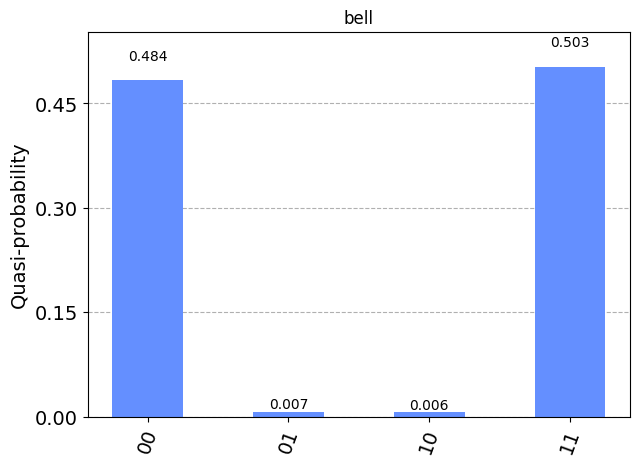

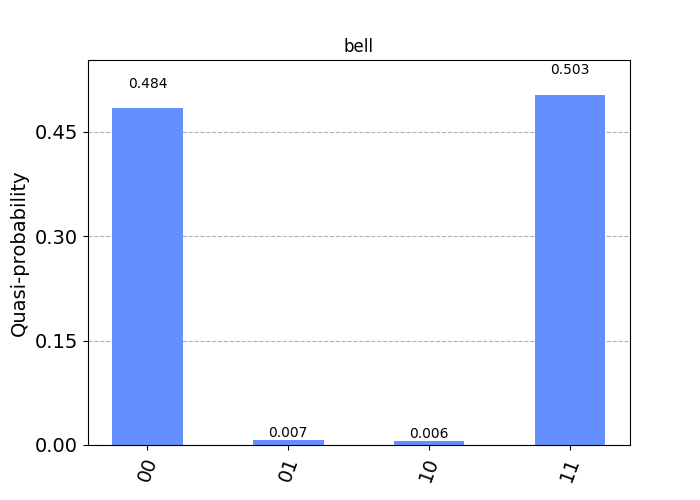

In [47]:
from qiskit.tools.visualization import plot_histogram
# Plot the results
plot_histogram(result.quasi_dists[0].binary_probabilities(), title="bell")